##### clean data 

In [2]:

import numpy as np
import pandas as pd    
import math
import matplotlib.pyplot as plt
import seaborn as sns


In [25]:
df = pd.read_csv('clean_merlot_cola.csv')
print(df.columns)
df[df['ID']=='A1006'].head(20)

Index(['ID', 'GENDER', 'co_medications', 'Date', 'Marker', 'Dose_mg',
       'Drug_concentration', 'Concentrations_n_hours', 'ctDNA_copies_ml',
       'mutation', 'Tumor_Length', 'Tumor_Width', 'lesion_site', 'Creatinine',
       'EGFR', 'Albumin', 'Bilirubin Total', 'ASAT', 'ALAT', 'ALP', 'ALAR'],
      dtype='object')


,ID,GENDER,co_medications,Date,Marker,Dose_mg,Drug_concentration,Concentrations_n_hours,ctDNA_copies_ml,mutation,...,Tumor_Width,lesion_site,Creatinine,EGFR,Albumin,Bilirubin Total,ASAT,ALAT,ALP,ALAR
248,A1006,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EGFR exon 19 p.(L747_T751del) and EGFR exon 20...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,A1006,NaN,NaN,2017-01-05,CT baseline,NaN,NaN,NaN,NaN,NaN,...,NaN,Primary tumour LUL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,A1006,NaN,NaN,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Liver segment 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,A1006,NaN,NaN,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Liver segment 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,A1006,NaN,NaN,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Adrenal gland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,A1006,NaN,NaN,2017-01-25,Dose start,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,96.0,70.0,44.0,13.0,21.0,20,84.0,20.0
254,A1006,NaN,"bisoprolol 5mg 1d, minocycline 100mg 1d, nadro...",2017-02-15,CT scan,NaN,NaN,NaN,NaN,NaN,...,NaN,Primary tumour LUL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255,A1006,NaN,NaN,2017-02-15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Liver segment 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256,A1006,NaN,NaN,2017-02-15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Liver segment 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,A1006,NaN,NaN,2017-02-15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Adrenal gland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#sns.pairplot(df, hue='ID', diag_kind='kde')

In [28]:
df = pd.read_csv('clean_merlot_cola.csv')


# Select the columns
df = df[['ID', 'Dose_mg', 'Date', 'lesion_site','Tumor_Length','Marker', 'Drug_concentration', 'ctDNA_copies_ml']]
df = df.dropna(subset=['Date'])
df = df.loc[~df['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce') # convert to datetime
df = df.sort_values(['ID', 'Date']) # sort by ID and Date
df = df.reset_index(drop=True) # reset index
df.loc[:, 'days'] = df.groupby('ID')['Date'].transform(lambda x: (x - x.min()).dt.days) # add days column


#############################################################################################
df['ID'] = df['ID'].replace('Dijke-Palar', 'A1017')
df = df[df['ID'] != '1'] # remover notes from the data
df.loc[(df['ID'] == 'A1009') & (df['days'] == 235), 'days'] = 230 # fix a mistake in the days column for A1009
df.loc[(df['ID'] == 'A1004') & (df['Date']=='2018-06-08'), 'Dose_mg'] = 0 # stops taking erlotinib
df = df[~((df['ID'] == 'A1006') & (df['Date'] == '2017-02-15'))] # this date only has an entry for 1/4 tumors 
print(df.head())
###############################################################################################

#### add site number column to simplify single tumors at different sites 
df['site_number'] = df.groupby('ID')['lesion_site'].transform(lambda x: pd.factorize(x)[0] + 1)
#### fill in missing values for dose with the value above
df['Dose_mg'] = df.groupby('ID')['Dose_mg'].transform(lambda x: x.ffill()) # so only the values below are filled
df['Dose_mg'] = df['Dose_mg'].fillna(0) # replace NaN with 0
df['dose_proportion'] = df['Dose_mg'] / 150 # add dose proportion column 
#### add volume column
def find_volume(length):# find volume of a sphere given diameter
    radius = length / 2
    return 4/3 * math.pi * radius ** 3
df['Tumor_Volume'] = df['Tumor_Length'].apply(find_volume)

df.to_csv('clean_erlotinib.csv',index=False)
df[df['ID']=='A1006'].head(30)
#df.head()

       ID  Dose_mg       Date             lesion_site  Tumor_Length  \
15  A1002      NaN 2017-03-21                     NaN           NaN   
16  A1002      NaN 2017-03-21                     NaN           NaN   
17  A1002      NaN 2017-03-31   Pleural effision left           NaN   
18  A1002      NaN 2017-03-31  Pleural metastasis LUL           7.4   
19  A1002      NaN 2017-03-31  Pleural metastasis LLL           7.8   

         Marker  Drug_concentration  ctDNA_copies_ml  days  
15          Lab                 NaN              NaN     0  
16          NaN                 NaN              NaN     0  
17  CT baseline                 NaN              NaN    10  
18          NaN                 NaN              NaN    10  
19          NaN                 NaN              NaN    10  


,ID,Dose_mg,Date,lesion_site,Tumor_Length,Marker,Drug_concentration,ctDNA_copies_ml,days,site_number,dose_proportion,Tumor_Volume
104,A1006,0.0,2017-01-05,Primary tumour LUL,45.0,CT baseline,NaN,NaN,0,1,0.000000,47712.938426
105,A1006,0.0,2017-01-05,Liver segment 1,17.6,NaN,NaN,NaN,0,2,0.000000,2854.543238
106,A1006,0.0,2017-01-05,Liver segment 6,20.0,NaN,NaN,NaN,0,3,0.000000,4188.790205
107,A1006,0.0,2017-01-05,Adrenal gland,15.0,NaN,NaN,NaN,0,4,0.000000,1767.145868
108,A1006,150.0,2017-01-25,NaN,NaN,Dose start,NaN,NaN,20,0,1.000000,NaN
113,A1006,150.0,2017-03-27,Primary tumour LUL,19.0,CT scan,NaN,NaN,81,1,1.000000,3591.364002
114,A1006,150.0,2017-03-27,Liver segment 1,6.5,NaN,NaN,NaN,81,2,1.000000,143.793314
115,A1006,150.0,2017-03-27,Liver segment 6,11.0,NaN,NaN,NaN,81,3,1.000000,696.909970
116,A1006,150.0,2017-03-27,Adrenal gland,0.0,NaN,NaN,NaN,81,4,1.000000,0.000000
117,A1006,100.0,2017-05-12,NaN,NaN,Dose reduction,NaN,NaN,127,0,0.666667,NaN


In [29]:
#### create dataframes for single and total tumors using groupby

def sum_or_nan(values): # to keep NaN if all values are NaN in a group
    return values.sum() if not np.all(values.isna()) else np.nan

# sum tumor lengths and volumes for each patient, day and site
single_tumors_df = df.groupby(['ID', 'days', 'site_number']).agg({'Tumor_Length': sum_or_nan,
                                                                   'Tumor_Volume': sum_or_nan, 
                                                                   'Dose_mg': 'mean', 
                                                                   'ctDNA_copies_ml': 'sum', 
                                                                   'dose_proportion':'mean'}).reset_index()
single_tumors_df.dropna(subset=['Tumor_Volume'], inplace=True) # drop rows with NaN in Tumor_Volume
single_tumors_df.reset_index(drop=True, inplace=True) # reset index
# subtract day 1 from each day to start days at 0 for each patient (lab happened before measurements)
single_tumors_df['days'] = single_tumors_df.groupby('ID')['days'].transform(lambda x: x - x.min())

# sum tumor lengths and volumes for each patient and day
total_tumors_df = single_tumors_df.groupby(['ID', 'days']).agg({'Tumor_Length': sum_or_nan,
                                                                 'Tumor_Volume': sum_or_nan, 
                                                                 'Dose_mg': 'mean', 
                                                                 'ctDNA_copies_ml': sum_or_nan,
                                                                 'dose_proportion':'mean'}).reset_index()
# rename columns
total_tumors_df = total_tumors_df.rename(columns={'Tumor_Length': 'Sum_tumor_lengths', 'Tumor_Volume': 'Sum_tumor_volume'})
total_tumors_df.dropna(subset=['Sum_tumor_lengths'], inplace=True) # drop rows with NaN in Sum_tumor_lengths
# remove mistakes in the data (suspicious or incomplete data)
total_tumors_df = total_tumors_df[~((total_tumors_df['ID'] == 'A1006') & (total_tumors_df['days'] == 41))]
total_tumors_df = total_tumors_df[~((total_tumors_df['ID'] == 'A1012') & (total_tumors_df['days'] == 536))]

total_tumors_df.reset_index(drop=True, inplace=True)
total_tumors_df['Sum_tumor_vol_cm'] = total_tumors_df['Sum_tumor_volume'] / 1000 # add cm3 column
total_tumors_df['Dose_mg'] = total_tumors_df['Dose_mg'].fillna(0.0) # fill NaN in dose with 0

# create dataframe with only patients with 10 or more days of data
ten_plus_df = total_tumors_df.groupby('ID').filter(lambda x: x['days'].nunique() >= 10) # keep only patients with 10 or more days of data
eight_plus_df = total_tumors_df.groupby('ID').filter(lambda x: x['days'].nunique() >= 8) # keep only patients with 8 or more days of data

# Create a df without the first point for each patient
no_first_point_df = total_tumors_df.groupby('ID').apply(lambda x: x.iloc[1:]).reset_index(drop=True)
no_first_point_df['days'] = no_first_point_df.groupby('ID')['days'].transform(lambda x: x - x.min())
# save the dataframes to csv
total_tumors_df.to_csv('total_tumors.csv', index=False)
single_tumors_df.to_csv('single_tumors.csv', index=False)
ten_plus_df.to_csv('ten_plus.csv', index=False)
eight_plus_df.to_csv('eight_plus.csv', index=False)
no_first_point_df.to_csv('no_first_point.csv', index=False)

#total_tumors_df[total_tumors_df['ID']=='A1002'].head(30)    
single_tumors_df[single_tumors_df['ID']=='A1006'].head(50)
#ten_plus_df[ten_plus_df['ID']=='A1012'].head(50)
#no_first_point_df[no_first_point_df['ID']=='A1004'].head(50)
#no_first_point_df.head(50)
#total_tumors_df.head(50)

,ID,days,site_number,Tumor_Length,Tumor_Volume,Dose_mg,ctDNA_copies_ml,dose_proportion
53,A1006,0,1,45.0,47712.938426,0.0,0.00,0.000000
54,A1006,0,2,17.6,2854.543238,0.0,0.00,0.000000
55,A1006,0,3,20.0,4188.790205,0.0,0.00,0.000000
56,A1006,0,4,15.0,1767.145868,0.0,0.00,0.000000
57,A1006,81,1,19.0,3591.364002,150.0,0.00,1.000000
58,A1006,81,2,6.5,143.793314,150.0,0.00,1.000000
59,A1006,81,3,11.0,696.909970,150.0,0.00,1.000000
60,A1006,81,4,0.0,0.000000,150.0,0.00,1.000000
61,A1006,137,1,16.0,2144.660585,100.0,0.00,0.666667
62,A1006,137,2,0.0,0.000000,100.0,0.00,0.666667


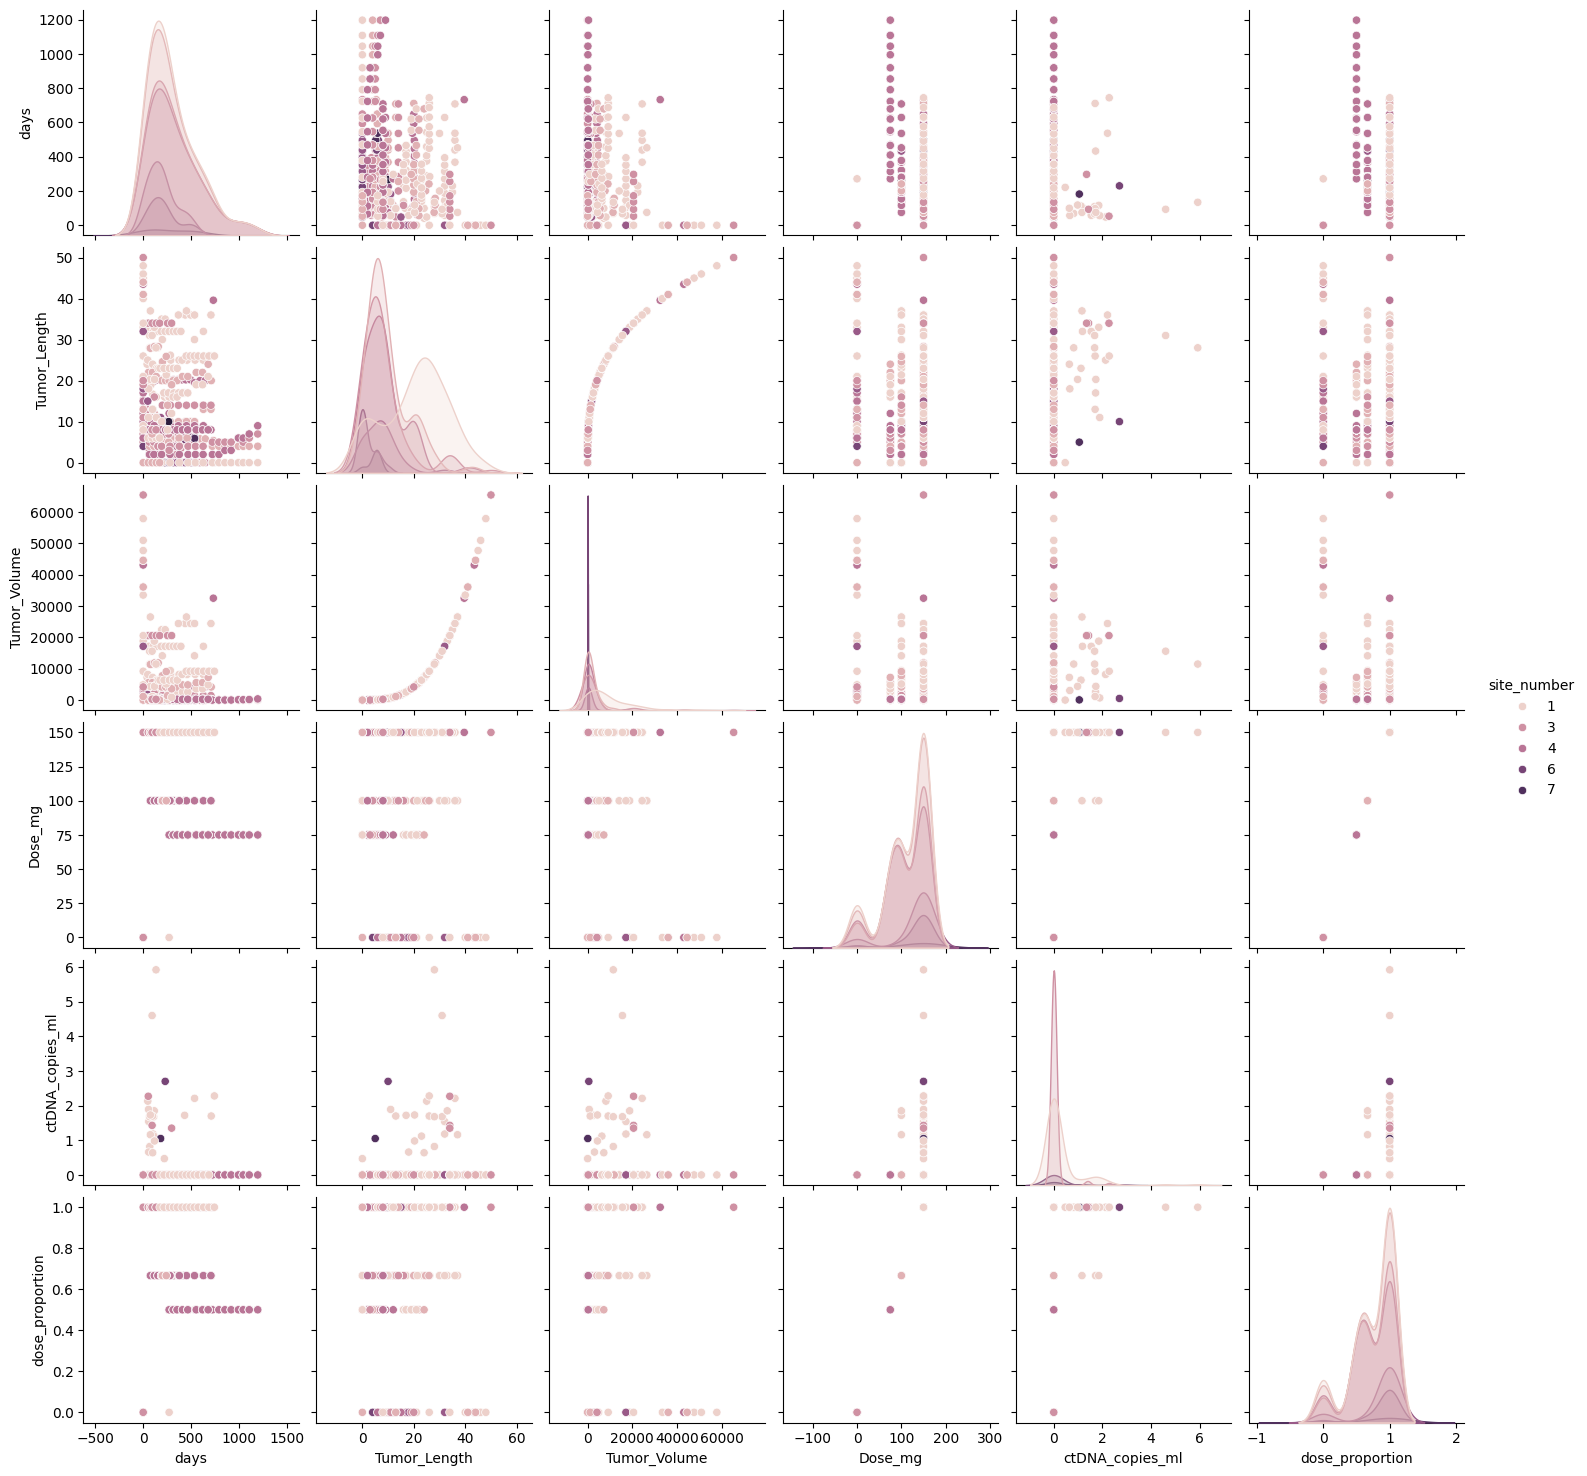

In [7]:
sns.pairplot(single_tumors_df, hue='site_number', diag_kind='kde')

In [8]:
max_values = total_tumors_df.groupby('ID')['Sum_tumor_vol_cm'].max()

for id, max_value in max_values.items():
    print(f"ID: {id}, Max Value: {max_value}")

ID: A1002, Max Value: 43.55957020237659
ID: A1004, Max Value: 18.816569198676063
ID: A1006, Max Value: 56.523417737261816
ID: A1007, Max Value: 39.80126982091773
ID: A1008, Max Value: 38.359369899106966
ID: A1009, Max Value: 56.72197895933931
ID: A1011, Max Value: 12.289910460843268
ID: A1012, Max Value: 50.248727296617545
ID: A1013, Max Value: 53.88093200294294
ID: A1014, Max Value: 0.8539896030008254
ID: A1016, Max Value: 104.35533037184335
ID: A1017, Max Value: 65.71792952289368
ID: E1008, Max Value: 40.9359994738262
ID: E1012, Max Value: 25.918662990891388


In [9]:
#single_tumors_df.head(20)
#total_tumors_df.head(50)
single_tumors_df[single_tumors_df['ID']=='A1004'].head(30)
#ten_plus_df.head(20)

,ID,days,site_number,Tumor_Length,Tumor_Volume,Dose_mg,ctDNA_copies_ml,dose_proportion
48,A1004,0,1,33.0,18816.569199,0.0,0.0,0.0
49,A1004,99,1,16.7,2438.641924,150.0,0.0,1.0
50,A1004,224,1,16.0,2144.660585,150.0,0.0,1.0
51,A1004,266,1,16.0,2144.660585,150.0,0.0,1.0
52,A1004,271,1,16.0,2144.660585,0.0,0.0,0.0


<Axes: xlabel='days', ylabel='Sum_tumor_vol_cm'>

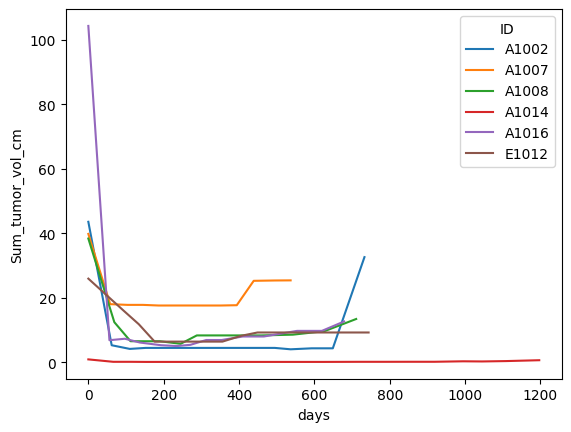

In [10]:
sns.lineplot(data=ten_plus_df, x='days', y='Sum_tumor_vol_cm', hue='ID')

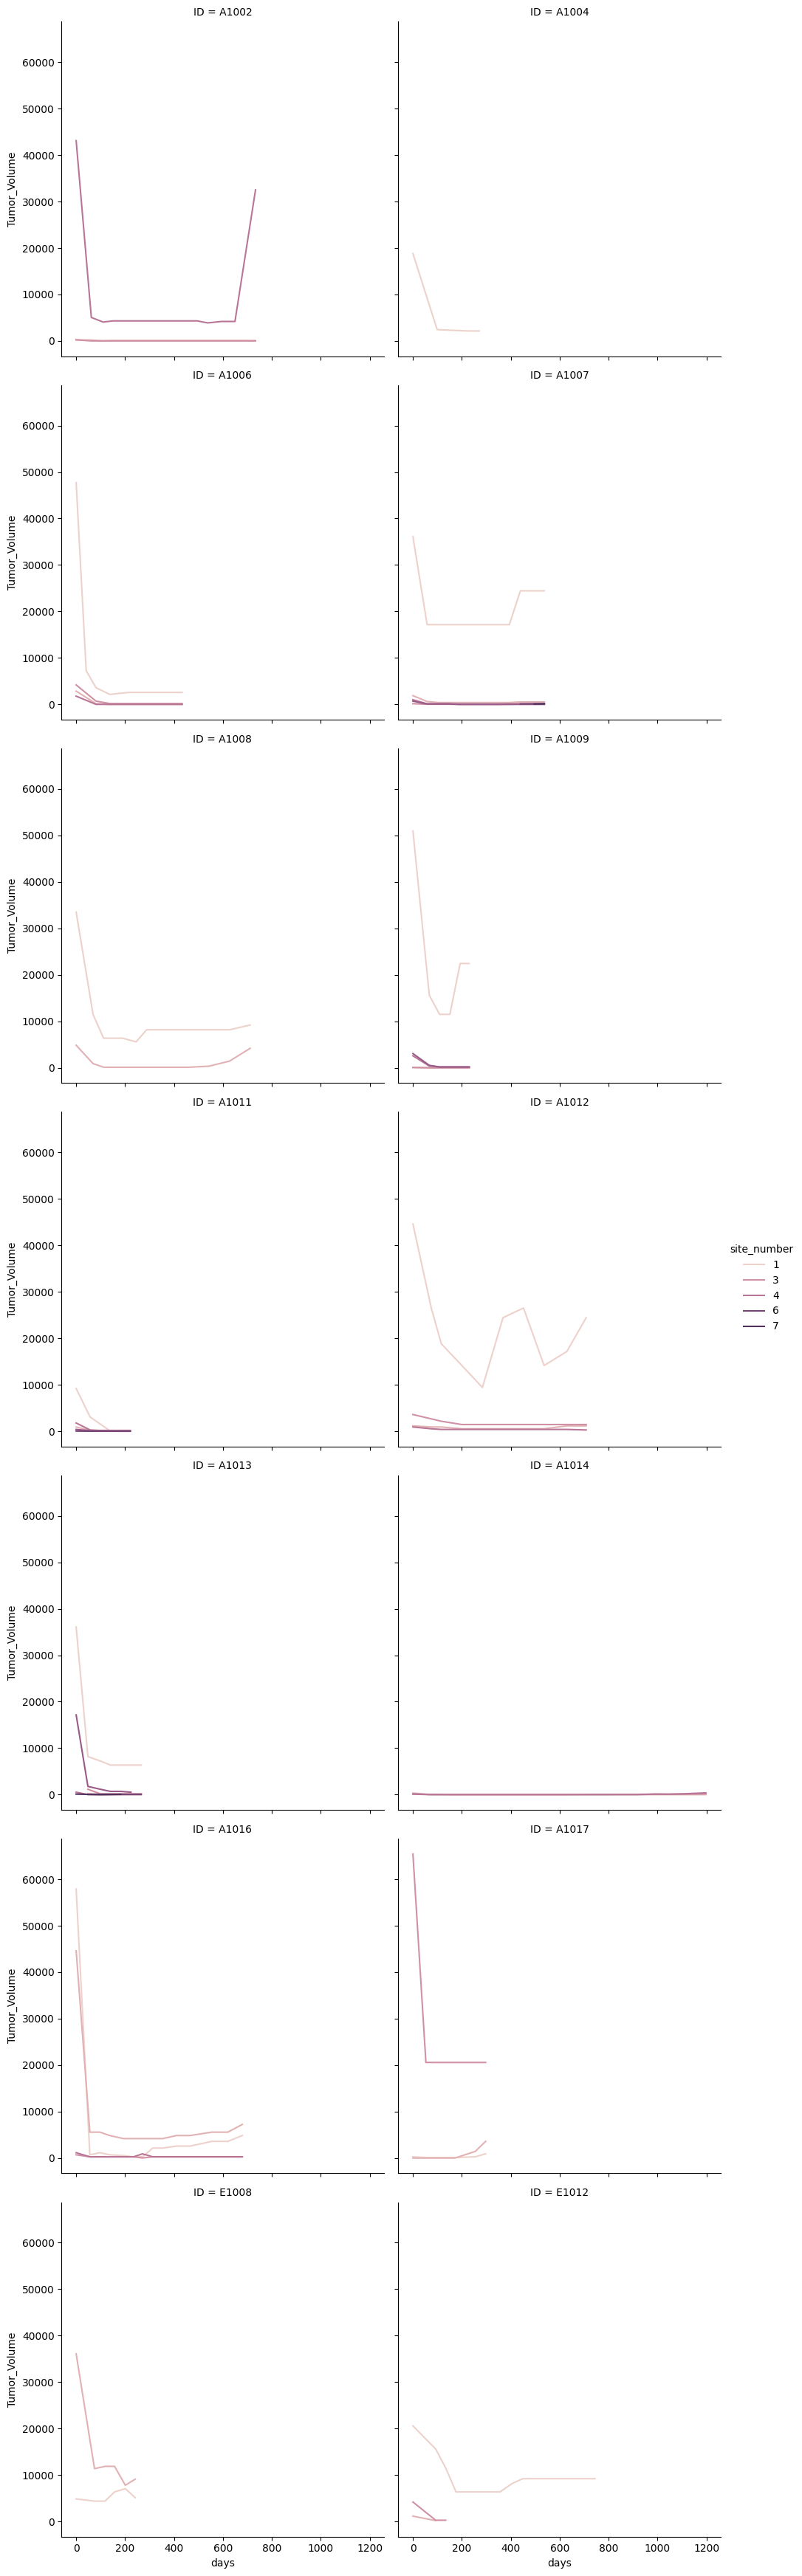

In [11]:
#sns.lineplot(data=single_tumors_df, x='days', y='Tumor_Volume', hue='ID')
# sns.relplot(data = df_filtered, x = 'Time', y = 'weight',
#  kind = 'line', err_style = 'band', errorbar = 'ci', col='Diet', col_wrap=2)

sns.relplot(data = single_tumors_df, x = 'days', y = 'Tumor_Volume', hue = 'site_number', kind = 'line', err_style = 'band', col='ID', col_wrap=2)